In [1]:
# import library

import warnings
warnings.filterwarnings('ignore')

# EDA & Visualisasi
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.ticker as mtick
style.use('fivethirtyeight')

# Preprocessing
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score

# Modeling
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc, classification_report
# from sklearn.metrics import ConfusionMatrixDisplay



In [2]:
# read file

df = pd.read_csv('Train.csv')

<Figure size 720x432 with 0 Axes>

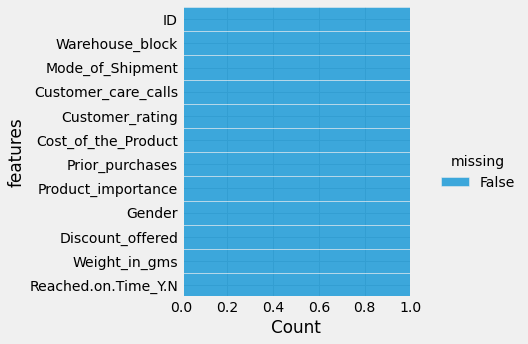

In [3]:
# Check if data is missing

plt.figure(figsize=(10,6))
ax = sns.displot(
    data=df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)

ax.set(ylabel='features')
plt.show()

Data tidak memiliki missing value sehingga tidak diperlukan Handle missing values

# Check if Data is Duplicated

In [4]:
df.duplicated().any()

False

In [5]:
df.duplicated(subset='ID').any()

False

Data tidak memiliki duplicated sehingga tidak diperlukan Handle duplicated data

In [6]:
# Misahin feature & target variable
df = pd.read_csv('Train.csv')
X = df.drop(['ID', 'Reached.on.Time_Y.N'], axis = 1)
y = df['Reached.on.Time_Y.N']

X.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms
0,D,Flight,4,2,177,3,low,F,44,1233
1,F,Flight,4,5,216,2,low,M,59,3088
2,A,Flight,2,2,183,4,low,M,48,3374
3,B,Flight,3,3,176,4,medium,M,10,1177
4,C,Flight,2,2,184,3,medium,F,46,2484


In [7]:
# Train & test pisah
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handling Outliers: Almas

In [8]:
stat_desc = X_train.describe().T
stat_desc.columns = ['count', 'mean', 'std', 'min', 'q1', 'median', 'q3', 'max']
stat_desc['IQR'] = stat_desc['q3'] - stat_desc['q1']
stat_desc

,count,mean,std,min,q1,median,q3,max,IQR
Customer_care_calls,8799.0,4.049096,1.138649,2.0,3.0,4.0,5.0,7.0,2.0
Customer_rating,8799.0,2.997386,1.411194,1.0,2.0,3.0,4.0,5.0,2.0
Cost_of_the_Product,8799.0,210.230367,48.051317,96.0,170.0,214.0,251.0,310.0,81.0
Prior_purchases,8799.0,3.581998,1.532722,2.0,3.0,3.0,4.0,10.0,1.0
Discount_offered,8799.0,13.366974,16.147015,1.0,4.0,7.0,10.0,65.0,6.0
Weight_in_gms,8799.0,3631.227867,1634.180615,1001.0,1838.0,4140.0,5045.0,7846.0,3207.0


In [9]:
# Outlier based on IQR
iqr = stat_desc.copy()

# Max right value = Q3 + 1.5 IQR
iqr['max_right'] = iqr['q3'] + 1.5 * iqr['IQR']

# Max left value = Q1 - 1.5 IQR
iqr['max_left'] = iqr['q1'] - 1.5 * iqr['IQR']

iqr['left_outlier'] = iqr['min'] < iqr['max_left']
iqr['right_outlier'] = iqr['max'] > iqr['max_right']

iqr

,count,mean,std,min,q1,median,q3,max,IQR,max_right,max_left,left_outlier,right_outlier
Customer_care_calls,8799.0,4.049096,1.138649,2.0,3.0,4.0,5.0,7.0,2.0,8.0,0.0,False,False
Customer_rating,8799.0,2.997386,1.411194,1.0,2.0,3.0,4.0,5.0,2.0,7.0,-1.0,False,False
Cost_of_the_Product,8799.0,210.230367,48.051317,96.0,170.0,214.0,251.0,310.0,81.0,372.5,48.5,False,False
Prior_purchases,8799.0,3.581998,1.532722,2.0,3.0,3.0,4.0,10.0,1.0,5.5,1.5,False,True
Discount_offered,8799.0,13.366974,16.147015,1.0,4.0,7.0,10.0,65.0,6.0,19.0,-5.0,False,True
Weight_in_gms,8799.0,3631.227867,1634.180615,1001.0,1838.0,4140.0,5045.0,7846.0,3207.0,9855.5,-2972.5,False,False


In [10]:
# Outlier based on IQR
filterprior = df['Prior_purchases'] <= iqr['max_right'].Prior_purchases
filterdisc = df['Discount_offered'] <= iqr['max_right'].Discount_offered

iqrfiltered = X_train[filterprior & filterdisc]
iqrfiltered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6341 entries, 7920 to 7187
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Warehouse_block      6341 non-null   object
 1   Mode_of_Shipment     6341 non-null   object
 2   Customer_care_calls  6341 non-null   int64 
 3   Customer_rating      6341 non-null   int64 
 4   Cost_of_the_Product  6341 non-null   int64 
 5   Prior_purchases      6341 non-null   int64 
 6   Product_importance   6341 non-null   object
 7   Gender               6341 non-null   object
 8   Discount_offered     6341 non-null   int64 
 9   Weight_in_gms        6341 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 544.9+ KB


In [11]:
# Handling outlier by setting a cap
cap = X_train.copy()
capdesc = cap.describe(percentiles = [.10,.50,.90]).T
capdesc

,count,mean,std,min,10%,50%,90%,max
Customer_care_calls,8799.0,4.049096,1.138649,2.0,3.0,4.0,6.0,7.0
Customer_rating,8799.0,2.997386,1.411194,1.0,1.0,3.0,5.0,5.0
Cost_of_the_Product,8799.0,210.230367,48.051317,96.0,144.0,214.0,269.0,310.0
Prior_purchases,8799.0,3.581998,1.532722,2.0,2.0,3.0,5.0,10.0
Discount_offered,8799.0,13.366974,16.147015,1.0,2.0,7.0,43.0,65.0
Weight_in_gms,8799.0,3631.227867,1634.180615,1001.0,1326.8,4140.0,5632.0,7846.0


In [12]:
prior_90 = capdesc['90%'].Prior_purchases
disc_90 = capdesc['90%'].Discount_offered

capfiltered = X_train.copy()

capfiltered['Prior_purchases'] = capfiltered['Prior_purchases'].apply(lambda x: prior_90 if x > prior_90 else x)
capfiltered['Discount_offered'] = capfiltered['Discount_offered'].apply(lambda x: disc_90 if x > disc_90 else x)

capfiltered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8799 entries, 7920 to 7187
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Warehouse_block      8799 non-null   object 
 1   Mode_of_Shipment     8799 non-null   object 
 2   Customer_care_calls  8799 non-null   int64  
 3   Customer_rating      8799 non-null   int64  
 4   Cost_of_the_Product  8799 non-null   int64  
 5   Prior_purchases      8799 non-null   float64
 6   Product_importance   8799 non-null   object 
 7   Gender               8799 non-null   object 
 8   Discount_offered     8799 non-null   float64
 9   Weight_in_gms        8799 non-null   int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 756.2+ KB


In [13]:
# Nambahin lagi y_train ke data untuk preprocessing selanjutnya
capfiltered['capfiltered_class'] = y_train.copy().reindex(capfiltered.index)
iqrfiltered['iqr_filtered_class'] = y_train.copy().reindex(iqrfiltered.index)
X_train['X_train_class'] = y_train.copy().reindex(X_train.index)

# Feature Encoding: Agastya

In [14]:
df_capfiltered = capfiltered
df_iqr_filtered = iqrfiltered
df_x_train = X_train

In [15]:
def cat_num (df):
    for typ,col in zip(X_train.dtypes.values,X_train.dtypes.index):
        if typ == "object":
             cat_col.append(col)
        else:
            num_col.append(col);

def cat_count(df):
    cat_columns = df[cat_col]
    for col in cat_columns:
        print(f'value counts dari column {col}')
        print(df[col].value_counts())
        print('---'*10, '\n');

In [16]:
cat_col=[]
num_col=[]
cat_num(df_capfiltered)
cat_count(df_capfiltered)

value counts dari column Warehouse_block
F    2910
B    1487
D    1470
A    1468
C    1464
Name: Warehouse_block, dtype: int64
------------------------------ 

value counts dari column Mode_of_Shipment
Ship      5981
Flight    1420
Road      1398
Name: Mode_of_Shipment, dtype: int64
------------------------------ 

value counts dari column Product_importance
low       4214
medium    3817
high       768
Name: Product_importance, dtype: int64
------------------------------ 

value counts dari column Gender
F    4475
M    4324
Name: Gender, dtype: int64
------------------------------ 



In [17]:
cat_col=[]
num_col=[]
cat_num(df_iqr_filtered)
cat_count(df_iqr_filtered)

value counts dari column Warehouse_block
F    2083
A    1067
D    1066
B    1066
C    1059
Name: Warehouse_block, dtype: int64
------------------------------ 

value counts dari column Mode_of_Shipment
Ship      4314
Flight    1043
Road       984
Name: Mode_of_Shipment, dtype: int64
------------------------------ 

value counts dari column Product_importance
low       3109
medium    2734
high       498
Name: Product_importance, dtype: int64
------------------------------ 

value counts dari column Gender
F    3213
M    3128
Name: Gender, dtype: int64
------------------------------ 



In [18]:
cat_col=[]
num_col=[]
cat_num(df_x_train)
cat_count(df_x_train)

value counts dari column Warehouse_block
F    2910
B    1487
D    1470
A    1468
C    1464
Name: Warehouse_block, dtype: int64
------------------------------ 

value counts dari column Mode_of_Shipment
Ship      5981
Flight    1420
Road      1398
Name: Mode_of_Shipment, dtype: int64
------------------------------ 

value counts dari column Product_importance
low       4214
medium    3817
high       768
Name: Product_importance, dtype: int64
------------------------------ 

value counts dari column Gender
F    4475
M    4324
Name: Gender, dtype: int64
------------------------------ 



Dari feature-feature di atas, maka akan dilakukan encoding sebagai berikut Labelling: Gender, Product_importance One Hot Encoding: Warehouse_block, Mode_of_Shipment

'Labelling' untuk ketiga dataset

In [19]:
mapping_gender = {
    'F' : 0,
    'M' : 1
}

mapping_product_importance = {
    'low' : 0,
    'medium' : 1,
    'high' : 2
}
#mapping Gender ketiga dataset
df_capfiltered['Gender_encoded'] = df_capfiltered['Gender'].map(mapping_gender)
df_iqr_filtered['Gender_encoded'] = df_iqr_filtered['Gender'].map(mapping_gender)
df_x_train['Gender_encoded'] = df_x_train['Gender'].map(mapping_gender)

#mapping Product_importance ketiga dataset
df_capfiltered['Product_importance_encoded'] = df_capfiltered['Product_importance'].map(mapping_product_importance)
df_iqr_filtered['Product_importance_encoded'] = df_iqr_filtered['Product_importance'].map(mapping_product_importance)
df_x_train['Product_importance_encoded'] = df_x_train['Product_importance'].map(mapping_product_importance)

## OHE

In [20]:
#dataset Train_capfiltered

for cat in ['Warehouse_block', 'Mode_of_Shipment']:
    onehots = pd.get_dummies(df_capfiltered[cat], prefix=cat)
    df_capfiltered = df_capfiltered.join(onehots)
    
#dataset Train_IQR_filtered

for cat in ['Warehouse_block', 'Mode_of_Shipment']:
    onehots = pd.get_dummies(df_iqr_filtered[cat], prefix=cat)
    df_iqr_filtered = df_iqr_filtered.join(onehots)
    
#dataset X_train

for cat in ['Warehouse_block', 'Mode_of_Shipment']:
    onehots = pd.get_dummies(df_x_train[cat], prefix=cat)
    df_x_train = df_x_train.join(onehots)

In [21]:
df_capfiltered = df_capfiltered.drop(columns=['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender'])
df_iqr_filtered = df_iqr_filtered.drop(columns=['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender'])
df_x_train = df_x_train.drop(columns=['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender'])

In [22]:
df_capfiltered.head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,capfiltered_class,Gender_encoded,Product_importance_encoded,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship
7920,4,1,261,2.0,9.0,4158,0,0,1,0,0,0,1,0,0,1,0
1529,3,3,162,2.0,26.0,1659,1,0,0,0,0,0,0,1,0,0,1
10521,3,2,221,2.0,9.0,4466,0,1,1,0,1,0,0,0,0,0,1
9558,3,5,157,4.0,2.0,4640,0,0,1,0,0,0,1,0,0,0,1
968,2,5,272,2.0,24.0,3638,1,1,0,1,0,0,0,0,1,0,0


In [23]:
df_iqr_filtered.head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,iqr_filtered_class,Gender_encoded,Product_importance_encoded,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship
7920,4,1,261,2,9,4158,0,0,1,0,0,0,1,0,0,1,0
10521,3,2,221,2,9,4466,0,1,1,0,1,0,0,0,0,0,1
9558,3,5,157,4,2,4640,0,0,1,0,0,0,1,0,0,0,1
1266,4,2,221,2,13,3097,1,0,0,0,0,0,1,0,0,0,1
7045,4,4,153,5,9,5818,0,1,1,0,0,0,0,1,0,0,1


In [24]:
df_x_train.head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,X_train_class,Gender_encoded,Product_importance_encoded,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship
7920,4,1,261,2,9,4158,0,0,1,0,0,0,1,0,0,1,0
1529,3,3,162,2,26,1659,1,0,0,0,0,0,0,1,0,0,1
10521,3,2,221,2,9,4466,0,1,1,0,1,0,0,0,0,0,1
9558,3,5,157,4,2,4640,0,0,1,0,0,0,1,0,0,0,1
968,2,5,272,2,24,3638,1,1,0,1,0,0,0,0,1,0,0


# Feature Transformation: Edo & Adhan

In [25]:
from sklearn.preprocessing import StandardScaler

df_cap = df_capfiltered
df_iqr = df_iqr_filtered
df_X = df_x_train

In [26]:
AB = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']
sc = StandardScaler()

df_cap[AB] = sc.fit_transform(df_cap[AB])
df_iqr[AB] = sc.fit_transform(df_iqr[AB])
df_X[AB] = sc.fit_transform(df_X[AB])

In [27]:
df_cap.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_care_calls,8799.0,-1.134701e-16,1.000057,-1.799688,-0.921405,-0.043121,0.835163,2.591731
Customer_rating,8799.0,1.266840e-16,1.000057,-1.415468,-0.706808,0.001852,0.710512,1.419173
Cost_of_the_Product,8799.0,2.350534e-16,1.000057,-2.377393,-0.837285,0.078455,0.848508,2.076432
Prior_purchases,8799.0,-1.754352e-16,1.000057,-1.307367,-0.363217,-0.363217,0.580933,1.525083
Discount_offered,8799.0,-9.835423e-17,1.000057,-0.844252,-0.619468,-0.394685,-0.169901,2.302718
Weight_in_gms,8799.0,-2.266122e-17,1.000057,-1.609600,-1.097388,0.311349,0.865175,2.579281
capfiltered_class,8799.0,5.966587e-01,0.490596,0.000000,0.000000,1.000000,1.000000,1.000000
Gender_encoded,8799.0,4.914195e-01,0.499955,0.000000,0.000000,0.000000,1.000000,1.000000
Product_importance_encoded,8799.0,6.083646e-01,0.642549,0.000000,0.000000,1.000000,1.000000,2.000000
Warehouse_block_A,8799.0,1.668371e-01,0.372852,0.000000,0.000000,0.000000,0.000000,1.000000


In [28]:
df_iqr.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_care_calls,6341.0,5.994959e-16,1.000079,-1.805111,-0.955418,-0.105726,0.743967,2.443351
Customer_rating,6341.0,3.559637e-17,1.000079,-1.419473,-0.710743,-0.002012,0.706719,1.415450
Cost_of_the_Product,6341.0,1.006222e-16,1.000079,-2.440735,-0.844519,0.129794,0.834617,1.995501
Prior_purchases,6341.0,1.028107e-16,1.000079,-1.301958,-0.290724,-0.290724,0.720510,1.731744
Discount_offered,6341.0,-2.137192e-16,1.000079,-1.408447,-0.844642,0.001067,0.564873,3.665804
Weight_in_gms,6341.0,2.559764e-17,1.000079,-1.820022,-1.234697,0.349198,0.795131,1.326180
iqr_filtered_class,6341.0,4.953477e-01,0.500018,0.000000,0.000000,0.000000,1.000000,1.000000
Gender_encoded,6341.0,4.932976e-01,0.499995,0.000000,0.000000,0.000000,1.000000,1.000000
Product_importance_encoded,6341.0,5.882353e-01,0.631942,0.000000,0.000000,1.000000,1.000000,2.000000
Warehouse_block_A,6341.0,1.682700e-01,0.374135,0.000000,0.000000,0.000000,0.000000,1.000000


In [29]:
df_X.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_care_calls,8799.0,-1.134701e-16,1.000057,-1.799688,-0.921405,-0.043121,0.835163,2.591731
Customer_rating,8799.0,1.266840e-16,1.000057,-1.415468,-0.706808,0.001852,0.710512,1.419173
Cost_of_the_Product,8799.0,2.350534e-16,1.000057,-2.377393,-0.837285,0.078455,0.848508,2.076432
Prior_purchases,8799.0,-1.503009e-16,1.000057,-1.032208,-0.379737,-0.379737,0.272734,4.187561
Discount_offered,8799.0,-8.942096e-17,1.000057,-0.765942,-0.580139,-0.394335,-0.208532,3.197864
Weight_in_gms,8799.0,-2.266122e-17,1.000057,-1.609600,-1.097388,0.311349,0.865175,2.579281
X_train_class,8799.0,5.966587e-01,0.490596,0.000000,0.000000,1.000000,1.000000,1.000000
Gender_encoded,8799.0,4.914195e-01,0.499955,0.000000,0.000000,0.000000,1.000000,1.000000
Product_importance_encoded,8799.0,6.083646e-01,0.642549,0.000000,0.000000,1.000000,1.000000,2.000000
Warehouse_block_A,8799.0,1.668371e-01,0.372852,0.000000,0.000000,0.000000,0.000000,1.000000


# Class Imbalance: Riyan

# Feature Engineering: Arsya, Almas, Afif